In [1]:
%load_ext lab_black
%load_ext watermark
%matplotlib inline

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pymc3 as pm
import scipy as sp
import seaborn as sns
import theano.tensor as tt
import warnings

from scipy.special import expit as logistic
from scipy.special import softmax

warnings.simplefilter(action="ignore", category=FutureWarning)
az.style.use("arviz-darkgrid")
RANDOM_SEED = 8927
np.random.seed(286)

PARTIES = ["farleft", "left", "green", "center", "right", "farright", "other"]

In [2]:
def mean_by_cluster(param: str, post_df: pd.DataFrame):
    """
    Compute posterior mean of param by cluster (arrondissement) and category (parties)
    param: parameter to aggregate by cluster. Either "a_district_f" for parameter scale, or "p_district" for outcome scale
    post_df: posterior distribution of model, as a pd.DataFrame
    """
    mean_df = pd.DataFrame(index=range(Nparties), columns=range(Ndistricts))
    mean_df.index.name = "Party"
    mean_df.columns.name = "Arrondissement"

    for i in range(Ndistricts):
        mean_df[i] = (
            post_df[
                [
                    f"{param}__{i}_0",
                    f"{param}__{i}_1",
                    f"{param}__{i}_2",
                    f"{param}__{i}_3",
                    f"{param}__{i}_4",
                    f"{param}__{i}_5",
                    f"{param}__{i}_6",
                ]
            ]
            .mean()
            .values
        )

    return mean_df.T


def plot_compare_true(
    party_id: int, true_means: np.ndarray, mean_clusters_varying: pd.DataFrame
):
    """
    Compare true proportions and varying-effects estimates.
    If estimates are close to true proportions, it means this model
    looks appropriate
    party_id: from 0 to 6, as there are 7 parties
    """
    plt.figure(figsize=(11, 5))

    plt.plot(
        np.arange(Ndistricts),
        pd.DataFrame(true_means)[party_id],
        "o",
        ms=6,
        alpha=0.8,
        label="True proportions",
    )
    plt.plot(
        np.arange(Ndistricts),
        mean_clusters_varying[party_id],
        "o",
        fillstyle="none",
        ms=8,
        markeredgewidth=1.5,
        alpha=0.8,
        label="Varying-effects estimates",
    )

    plt.xticks(range(Ndistricts), range(1, Ndistricts + 1))
    plt.xlabel("Arrondissement")
    plt.ylabel(f"Share party {party_id} ({PARTIES[party_id]})")
    plt.legend(ncol=2, frameon=True, framealpha=0.5)

Let's load the data and transform every missing values to 0: except for the "other" category, when a party is missing, this means that it got 0 votes, so it makes sense to replace NaNs by 0s. Note however that these zeros do not come from the multinomial process - unlike the zeros in the "other" category, but from an earlier process that determines if any given party competes in the election. We'll deal with that below, but let's already remark that this looks a lot like a zero-inflated process...

In [3]:
d = pd.read_excel("data/results_by_arrdmt.xlsx", index_col=0)
# A party that wasn't there won 0 ballots:
d[PARTIES] = d[PARTIES].fillna(0).astype(int)
d

,date,ville,arrondissement,N,farleft,left,green,center,right,farright,other,type
0,2008-05-23,Paris,1,6127,75,2289,439,531,2641,152,0,municipale
1,2014-03-25,Paris,1,6079,154,1663,659,0,3144,306,153,municipale
2,2017-04-23,Paris,1,9026,1231,659,0,3561,2831,443,301,president
3,2017-06-11,Paris,1,6282,434,418,363,2958,1525,148,436,legislative
4,2008-05-23,Paris,2,6736,90,2231,2016,621,1543,167,68,municipale
...,...,...,...,...,...,...,...,...,...,...,...,...
75,2017-06-11,Paris,19,50024,9798,4488,5463,18429,3790,2129,5927,legislative
76,2008-05-23,Paris,20,56285,4776,21568,5329,4114,4076,2033,14389,municipale
77,2014-03-25,Paris,20,54966,5692,20502,5990,0,11467,4112,7203,municipale
78,2017-04-23,Paris,20,89574,28512,12469,0,27399,11451,5305,4438,president


What's the proportion of zeros in the respective categories?

In [12]:
1 - d[PARTIES].astype(bool).mean(axis=0).round(2)

farleft     0.05
left        0.00
green       0.25
center      0.25
right       0.00
farright    0.00
other       0.08
dtype: float64

Note that zeros in the category "other" are real multinomial zeros, while zeros in farleft, green and center result from the absence of these categories in the multinomial - they were eliminated upstream from the multinomial trials and are therefore not real multinomial zeros. Also note that the zero-inflated categories are not "jointly-inflated" (green is not necessaricly 0 when center is, and vice-versa).

Now let's look at each category's distribution (we zoom-in to really see zero-inflations):

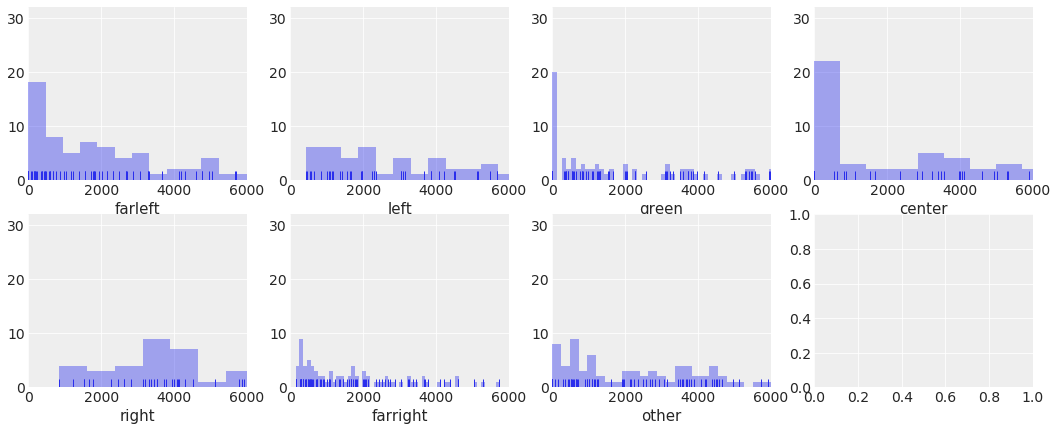

In [13]:
fig, axes = plt.subplots(2, 4, figsize=(18, 7))
i = 0
for line in axes:
    for col in line:
        try:
            sns.distplot(d[PARTIES[i]], bins=60, kde=False, rug=True, ax=col)
            col.set_xlim([0, 6_000])
            col.set_ylim([0, 32])
            i += 1
        except IndexError:
            continue

That's not the best plot, but we can see that farleft, green and center do have a tendency to zero-inflation. Now, how can we model this mixed process?

We're gonna run an intercept-only hierarchical softmax regression with simulated data, to see if this model indeed captures the structure of the data. If that's the case, we'll be able then to add predictors and a covariance structure between slopes and intercepts. First, let's define index variables:

In [4]:
district_id, districts = d.arrondissement.factorize(sort=True)
Ndistricts = len(districts)
Nparties = len(PARTIES)
N = d.N.values
R_obs = d[PARTIES].values  # for the real model

# which parties are available for choice ("other" always is):
parties_available = pd.concat(
    [
        d[PARTIES].astype(bool).astype(int).iloc[:, :-1],
        pd.Series([1] * len(d), name="other"),
    ],
    axis=1,
).values

And now we simulate zero-inflated multinomial data. The zero inflation comes from the fact that sometimes, some parties don't compete in a given election. Here, this process is simulated exactly like it happened in reality for the four elections in our dataset - thanks to the variable `parties_available`. So, during the four elections, some parties are not available in all or some districts.

In [59]:
# -1.8 on logit scale is about 14% on p scale
true_a = pm.Normal.dist(-1.8, 0.1, shape=Nparties - 1).random()
print("true_a: ", true_a)
true_sigma_district = pm.Exponential.dist(1.0).random()  # one sd per category?
print("true_sigma_district: ", true_sigma_district)

true_a_district = pm.Normal.dist(
    true_a, true_sigma_district, shape=(Ndistricts, Nparties - 1)
).random()
true_a_other = np.full(shape=(Ndistricts, 1), fill_value=-2.2)
true_a_district_f = np.hstack((true_a_district, true_a_other))

# preferences of each district:
true_p_district = softmax(true_a_district_f, axis=1)
print("true_p_district: ", true_p_district.shape)
# preferences of each district, for 4 elections:
true_lat_p = true_p_district[district_id]

# keep only preferences for available parties:
true_slot_prob = parties_available * true_lat_p
# normalize preferences:
true_slot_prob = true_slot_prob / np.sum(true_slot_prob, axis=1, keepdims=True)

sim_R = pm.Multinomial.dist(n=N, p=true_slot_prob).random()
print("sim_R: ", sim_R.shape)

true_a:  [-1.70957646 -1.63789811 -1.92710612 -1.88548654 -1.90589303 -1.73387948]
true_sigma_district:  2.6699495443806813
true_p_district:  (20, 7)
sim_R:  (80, 7)


In [60]:
with pm.Model() as m_multi:
    a = pm.Normal("a", -1.8, 0.1, shape=Nparties - 1)
    sigma_district = pm.Exponential("sigma_district", 1.0)  # one sd per category?

    a_district = pm.Normal(
        "a_district", a, sigma_district, shape=(Ndistricts, Nparties - 1)
    )
    a_pivot = tt.as_tensor_variable(np.full(shape=(Ndistricts, 1), fill_value=-2.2))
    a_district_f = tt.horizontal_stack(a_district, a_pivot)

    p_district = pm.Deterministic("p_district", tt.nnet.softmax(a_district_f))
    lat_p = tt.nnet.softmax(a_district_f[district_id])

    # zero-inflation process:
    # keep only preferences for available parties:
    slot_prob = parties_available * lat_p
    # normalize preferences:
    slot_prob = slot_prob / tt.sum(slot_prob, axis=1, keepdims=True)
    R = pm.Multinomial("R", n=N, p=slot_prob, observed=sim_R)

    trace_multi = pm.sample(
        2000, tune=3000, cores=2, random_seed=RANDOM_SEED, init="adapt_diag"
    )

post_multi = pm.trace_to_dataframe(trace_multi)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a_district, sigma_district, a]
Sampling 2 chains, 0 divergences: 100%|██████████| 10000/10000 [06:31<00:00, 25.57draws/s]


array([<matplotlib.axes._subplots.AxesSubplot object at 0x1c28e318d0>,
      dtype=object)

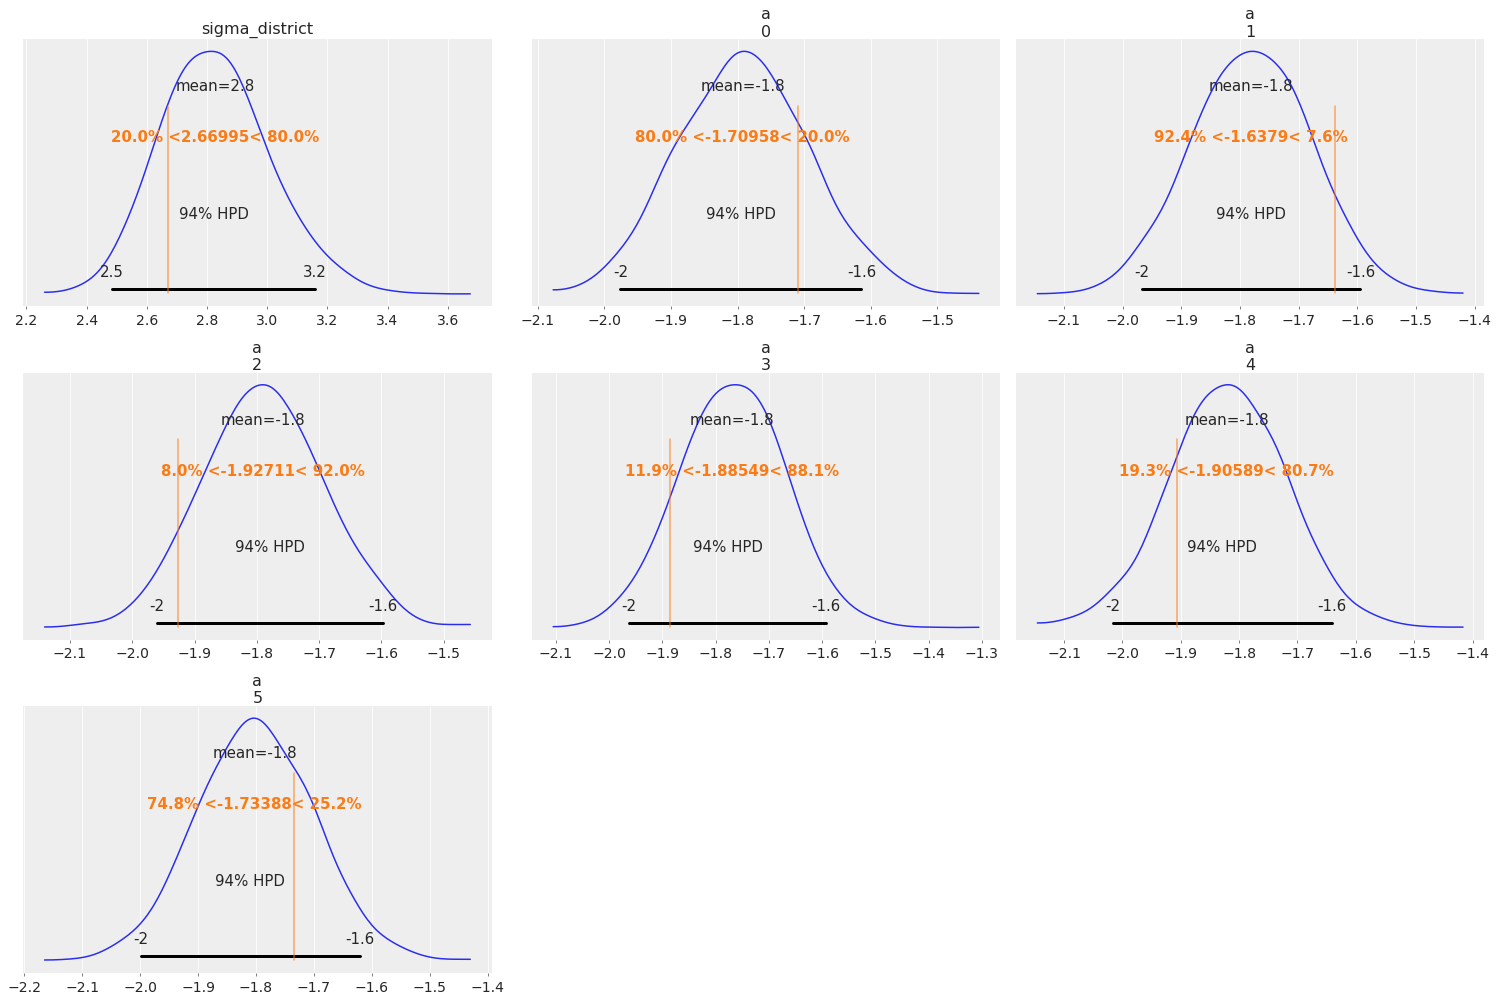

In [61]:
a_vals = [{"a_dim_0": i, "ref_val": true_a[i]} for i in range(len(true_a))]
s_vals = [{"ref_val": true_sigma_district}]

az.plot_posterior(
    trace_multi,
    var_names=["sigma_district", "a"],
    ref_val={"sigma_district": s_vals, "a": a_vals},
);

# lines = [("a", {"a_dim_0": i}, true_a[i]) for i in range(len(true_a))]

# az.plot_trace(
# trace_multi,
#  var_names=["sigma_district", "a"],
#   lines=[("sigma_district", {}, true_sigma_district)] + lines,
# )

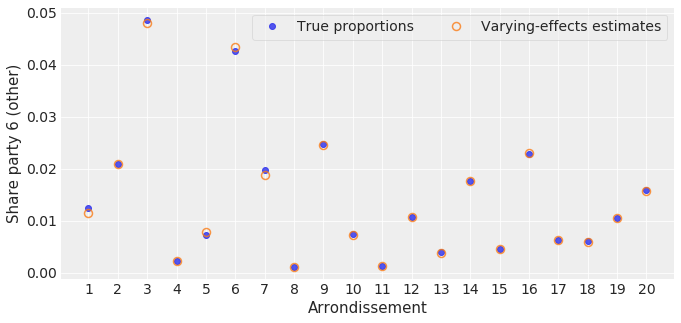

In [95]:
p_district_mean = mean_by_cluster("p_district", post_multi)
plot_compare_true(6, true_p_district, p_district_mean)

Now we'll try a cool trick and model the same multinomial data as... a series of Poisson regression - yeah, statistics is *that* fun! We'll still use a hierarchical intercept-only regression, but the nice thing here is that the zero-inflation will be handled directly by a ZIPoisson likelihood when appropriate - so we'll get an estimation of the probability of zero-inflation for free.

First however, we have to choose reasonable priors for the intercepts of the Poisson (regular process) and binomial (zero-inflation) regressions:

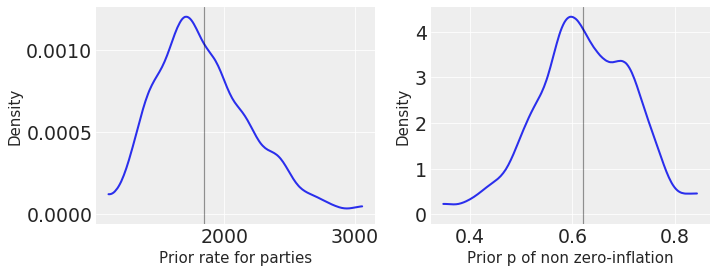

In [26]:
fig, ax = plt.subplots(1, 2, figsize=(11, 4))
a_l = pm.Normal.dist(mu=7.5, sd=0.2).random(size=500)
a_p = pm.Normal.dist(mu=0.5, sd=0.4).random(size=500)

az.plot_kde(np.exp(a_l), ax=ax[0])
ax[0].axvline(np.exp(a_l).mean(), linewidth=1.2, color="k", alpha=0.4)
ax[0].set_xlabel("Prior rate for parties")
ax[0].set_ylabel("Density")

az.plot_kde(logistic(a_p), ax=ax[1])
ax[1].axvline(logistic(a_p).mean(), linewidth=1.2, color="k", alpha=0.4)
ax[1].set_xlabel("Prior p of non zero-inflation")
ax[1].set_ylabel("Density")

And here is the model:

In [85]:
# add predictor

# Poisson model of each party's rate:
with pm.Model() as m_pois:
    a = pm.Normal("a", 7.5, 0.2, shape=Nparties)
    sigma_district = pm.Exponential("sigma_district", 1.0)  # one sd per category?

    # latent Poisson regression:
    a_district = pm.Normal(
        "a_district", a, sigma_district, shape=(Ndistricts, Nparties)
    )
    # get rates by district:
    lam_district = pm.math.exp(a_district)
    # get back p from rates by district:
    p_district = pm.Deterministic(
        "p_district", lam_district / tt.sum(lam_district, axis=1, keepdims=True)
    )
    # rates observed several times per district:
    lam = pm.math.exp(a_district[district_id])

    # zero-inflation process:
    ap = pm.Normal("ap", 0.5, 0.4, shape=3)  # also as hierarchical?
    p_ni = pm.math.invlogit(ap)

    fl = pm.ZeroInflatedPoisson("fl", 1.0 - p_ni[0], lam[:, 0], observed=sim_R[:, 0])
    l = pm.Poisson("l", lam[:, 1], observed=sim_R[:, 1])
    g = pm.ZeroInflatedPoisson("g", 1.0 - p_ni[1], lam[:, 2], observed=sim_R[:, 2])
    c = pm.ZeroInflatedPoisson("c", 1.0 - p_ni[2], lam[:, 3], observed=sim_R[:, 3])
    r = pm.Poisson("r", lam[:, 4], observed=sim_R[:, 4])
    fr = pm.Poisson("fr", lam[:, 5], observed=sim_R[:, 5])
    o = pm.Poisson("o", lam[:, 6], observed=sim_R[:, 6])

    trace_pois = pm.sample(2000, tune=3000, cores=2, random_seed=RANDOM_SEED)

post_pois = pm.trace_to_dataframe(trace_pois)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [ap, a_district, sigma_district, a]
Sampling 2 chains, 0 divergences: 100%|██████████| 10000/10000 [03:41<00:00, 45.25draws/s]


In [86]:
az.summary(trace_pois, round_to=2, var_names=["p_district"])

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
"p_district[0,0]",0.96,0.0,0.96,0.96,0.0,0.0,4112.56,4112.56,4115.02,2838.29,1.0
"p_district[0,1]",0.00,0.0,0.00,0.00,0.0,0.0,4454.96,4454.96,3907.92,2378.71,1.0
"p_district[0,2]",0.02,0.0,0.01,0.02,0.0,0.0,4426.96,4384.50,4423.74,2651.74,1.0
"p_district[0,3]",0.00,0.0,0.00,0.00,0.0,0.0,3539.11,3539.11,3435.91,2502.14,1.0
"p_district[0,4]",0.01,0.0,0.01,0.01,0.0,0.0,3627.76,3627.76,3616.78,2438.78,1.0
...,...,...,...,...,...,...,...,...,...,...,...
"p_district[19,2]",0.20,0.0,0.20,0.20,0.0,0.0,4671.28,4666.09,4625.48,1744.44,1.0
"p_district[19,3]",0.75,0.0,0.74,0.75,0.0,0.0,4409.72,4409.72,4404.82,2759.65,1.0
"p_district[19,4]",0.00,0.0,0.00,0.00,0.0,0.0,4313.71,4277.46,4304.61,2942.50,1.0
"p_district[19,5]",0.00,0.0,0.00,0.00,0.0,0.0,4117.12,4104.14,4121.10,2846.06,1.0


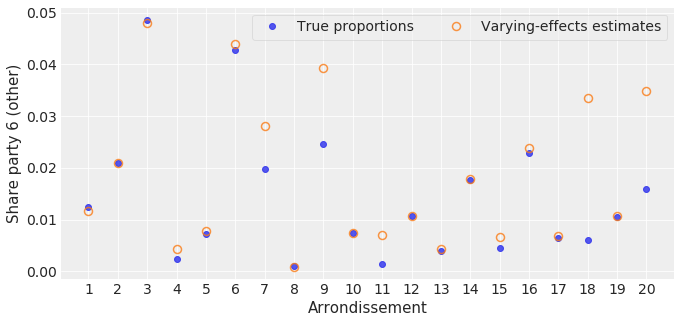

In [94]:
# p_district_mean_pois = mean_by_cluster("p_district", post_pois)
plot_compare_true(6, true_p_district, p_district_mean_pois)

In [1]:
# https://github.com/pymc-devs/pymc3/blob/master/pymc3/distributions/multivariate.py
# https://github.com/pymc-devs/pymc3/blob/master/pymc3/distributions/discrete.py

# https://discourse.pymc.io/t/the-zero-inflated-exponential/2538
# https://discourse.pymc.io/t/literature-on-implementing-a-zero-inflated-beta-likelihood/2503
# https://discourse.pymc.io/t/zero-inflated-poisson-log-lik/2664
# https://discourse.pymc.io/t/sampling-from-a-learned-mixture-of-zeros-and-lognormal/3671/2

# https://www.birs.ca/workshops/2019/19w5128/files/slides_ZIGDM.pdf
# https://rdrr.io/cran/miLineage/man/ZIGDM.html